# 20240416
sarahfong

- Here, HOB were exposed for 60' to control or physiostim
- IL6 refers to the IL6-1 qPCR probe, not IL6-original, or IL6-2

In [1]:
import config_readwrite as crw
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import sys

import warnings
warnings.filterwarnings("ignore")
from statsmodels.formula.api import ols

import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# read and write to config

In [33]:
CONFIG = "/wynton/home/ahituv/fongsl/EMF/config.ini"

config, cfn = crw.read(CONFIG)

### PARAMS ###
DATE= "20240411"
CL='HOb'
N_PLATES = 1
PLATE_TYPE=96 # 96 or 384 well

COMPARISONS = [#("Control 30' exp1", "PEMF 60' exp1"),
               ("Control 60' exp3", "PEMF 60' exp3")]

GENE_LIST = ['IL6', 'HSP70A']

### CONFIG ###
section = f"{DATE}_PEMF_{CL}"
crw.check(config, section)

# read
DATA_PATH = config["local_path"]["data"]

# load
QPCR_PATH = os.path.join(DATA_PATH, "qpcr", section)
PLATE1="plate1.xls"

if N_PLATES>1:
    PLATE2="plate2.xls"
    config[section]["plate2"] = f"%(path)s/{PLATE2}"
    PLATES = [PLATE1, PLATE2]
else:
    PLATES=[PLATE1]


COMBINED = "qRT_PEMF.tsv"
LABELS = f"{DATE}_qPCR_labels.xlsx"

# write
config[section]["path"] = QPCR_PATH
config[section]["plate1"] = f"%(path)s/{PLATE1}"

config[section]["labels"] = f"%(path)s/{LABELS}"
config[section]["plate_combined"] = f"%(path)s/{COMBINED}"

crw.write(config, cfn)

RE = "/wynton/home/ahituv/fongsl/EMF/results/"
RE_DDCT = os.path.join(RE, f"{DATE}.ddCTs.{CL}.tsv")

# go to datapath
os.chdir(QPCR_PATH)

In [34]:
len(COMPARISONS)

1

# labels

In [3]:
sample=pd.read_excel(LABELS, sheet_name="sample")
sample = sample.rename(columns={"Sample":'sample_id',
                               "Sample_group":"sample_name", 
                               "Replicate_w": "rep", 
                               "Plate":"plate"
                              })
sample

,sample_id,sample_name,rep,Experiment
0,S1,Control 60' exp3,1,3
1,S2,Control 60' exp3,2,3
2,S3,Control 60' exp3,3,3
3,S4,PEMF 60' exp3,1,3
4,S5,PEMF 60' exp3,2,3
5,S6,PEMF 60' exp3,3,3


## function

In [35]:
df

,Well Position,CT,plate,col_pos_x,primers,row,col_pos_y,sample_id,sample_name,rep,Experiment
0,A1,None,plate1.xls,1,GAPDH,A,1,noRT,noRT,NaN,NaN
1,A2,None,plate1.xls,2,GAPDH,A,2,noRT,noRT,NaN,NaN
2,A3,None,plate1.xls,3,GAPDH,A,3,noRT,noRT,NaN,NaN
3,A4,NaN,plate1.xls,4,GAPDH,A,4,noRT,noRT,NaN,NaN
4,A5,NaN,plate1.xls,5,GAPDH,A,5,noRT,noRT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
91,H8,26.947449,plate1.xls,8,HSP70A,H,8,S2,Control 60' exp3,2.0,3.0
92,H9,26.927002,plate1.xls,9,HSP70A,H,9,S3,Control 60' exp3,3.0,3.0
93,H10,27.404381,plate1.xls,10,HSP70A,H,10,S4,PEMF 60' exp3,1.0,3.0
94,H11,27.144958,plate1.xls,11,HSP70A,H,11,S5,PEMF 60' exp3,2.0,3.0


In [43]:
for i in list(df["Experiment"].unique()):
    
        print("None", i)
    else:
        print(i)

None nan
3.0


In [44]:
def plateToLongform(df, col_name):
    """transpose plate format into longform dataframe, name column"""
    transpose={}
    for n, row in df.iterrows():
        transpose[n] = row
    
    # make dataframe
    dfT = pd.DataFrame(pd.concat(transpose.values())).reset_index()

    # rename columns
    dfT.columns = ["col_pos", col_name]
    return dfT
    

def mergeDataFrames(df1, df2, col=None):
    """left merge two dataframes on index"""
    
    if col != None:
        merged = pd.merge(df1, df2, on=col)
    else:
        merged = pd.merge(df1, df2, left_index=True, right_index=True)
    return merged

def computeCT(df, control_gene):

    # mean ACTB CT per sample
    mean_ctrl = df[df['primers'] == control_gene].groupby('sample_name')['CT'].mean().reset_index()

    # rename columns
    mean_ctrl.rename(columns={'CT': 'Control_mean'}, inplace=True)


    # Merge mean ACTB values per sample
    test = pd.merge(df, mean_ctrl, on='sample_name', how='left')

    # dCT = obs CT - ACTB mean CT
    test['dCT'] = test['CT'] - test['Control_mean']

    # per experiment, compute ddCT
    results={}  # collect results per experiment
    
    # mean dCT per gene for control sample
    for experiment in list(df["Experiment"].unique()):  
        if str(i)!="nan":

            test_ex = test.loc[test["Experiment"]== experiment].copy()
            control_dCTs = test_ex[test_ex['sample_name'].str.contains('Control')].groupby(['primers'])['dCT'].mean().reset_index()  

            # rename columns
            control_dCTs.rename(columns={'dCT': 'Control_dCT_mean'}, inplace=True)

            # Merge control sample dCT values per gene
            test_ex = pd.merge(test_ex, control_dCTs, on='primers', how='left')


            # ddCT = mean(dCT) sample - mean(dCT) control sample
            test_ex['ddCT'] = test_ex['dCT'] - test_ex['Control_dCT_mean']

            # Assuming 'test' contains the 'ddCT' values for each gene

            # Calculate fold change using the formula 2^(-ddCT)
            test_ex['fold_change'] = 2 ** (-test_ex['ddCT'])

            results[experiment] = test_ex
    return pd.concat(results.values())

def plotDct(df, gene, control_gene, comparisons, date):
    """per gene, plot dCT"""

    # subset data to gene, removing noRT, lines w no ddCT
    data_ = df_.loc[(df_["primers"] == gene) &
                    (df_['sample_name'] != "noRT") &
                    (~df_['ddCT'].isna())
                    ].copy()

    # compute the mean fold change
    plot = data_.groupby(["sample_name", "primers",  "rep"])[
        "fold_change"].mean().reset_index()

    # stats
    statPS, p1 = stats.ttest_ind(data_.loc[data_["sample_name"] == comparisons[0][0], "dCT"].to_list(),
                                 data_.loc[data_["sample_name"] == comparisons[0][1], "dCT"].to_list())

    print(f"{comparisons[0][1]} v. ctrl dCT", gene, p1)

    fig, ax=plt.subplots(figsize=(6,6))
    x = "sample_name"
    y = 'fold_change'
    hue = "rep"
    data = plot
    order = [comparisons[0][0], comparisons[0][1]]
    print(x, y)
    sns.boxplot(data=data,
                x=x, y=y,
                order=order,
                color="grey",

                )

    sns.swarmplot(data=data, x=x, y=y,
                  hue=hue,
                  palette="Set2",
                  order=order,
                  alpha=0.8, size=10)

    ax.set(xlabel=f't-test p={"{:.2E}".format(p1)}',
           ylabel='Fold Change (2**-ddCT)',
           title=gene,
           ylim=(0.2, 4)

           )

    ax.axhline(1, ls="--", color="grey", alpha=0.2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                       horizontalalignment="right")

    plt.legend(title='replicate', bbox_to_anchor=(1, 1), frameon=False)

    plt.savefig(os.path.join(
        RE, f"{date}_hs.{control_gene}.{gene}.pdf"), bbox_inches="tight")

    # Show the plot
    plt.show()
    
def plot_heatmap(df, value_var):
    """plot a heatmap of CT, or dCT across the plate"""
    df["row"] = df["Well Position"].apply(lambda x: list(x)[0])
    table = df[[value_var, "row", "col_pos"]].copy().drop_duplicates().pivot(
                index="row", columns="col_pos", values=value_var).fillna(0)
    sns.heatmap(table, 
           square=True, 
           cbar_kws={"label":value_var}, 
            cmap="bwr"
           )


## primers

In [7]:
# assumes no header names
SHEETS = ["platemap1-primers", "platemap2-primers"][:N_PLATES]
primer_dict={}
for sheet in SHEETS:
    primers=pd.read_excel(LABELS, sheet_name=sheet,
                          header=None, names=np.arange(1,13))

    col_name="primers"
    primersT= plateToLongform(primers, col_name)
    
    # edit names
    primersT.loc[primersT["primers"]=="Hsp70c", 'primers'] = "HSP70C"
    primersT.loc[primersT["primers"]=="HSP70c", 'primers'] = "HSP70C"

    # add to dictionary
    primer_dict[sheet] = primersT

# drop the old index
primersT = pd.concat(primer_dict.values()).reset_index(drop=True)
primersT

,col_pos,primers
0,1,GAPDH
1,2,GAPDH
2,3,GAPDH
3,4,GAPDH
4,5,GAPDH
...,...,...
91,8,HSP70A
92,9,HSP70A
93,10,HSP70A
94,11,HSP70A


## cdna

In [8]:
CDNAS = ["platemap1-cdna", "platemap2-cdna"][:N_PLATES]
cdna_dict={}
for sheet in CDNAS:

    cdna = pd.read_excel(LABELS, sheet_name=sheet, 
                         header=None, names=np.arange(1, 13))

    col_name = "sample_id"
    cdnaT = plateToLongform(cdna, col_name)
    
    # rename empty columns
    cdnaT.loc[cdnaT['sample_id']=="empty", 'sample_id'] = 'noRT'
    cdnaT.loc[cdnaT['sample_id'].isna(), 'sample_id'] = 'noRT'
    
    # add to dictionary
    cdna_dict[sheet] = cdnaT

cdnaT = pd.concat(cdna_dict.values()).reset_index(drop=True)
cdnaT

,col_pos,sample_id
0,1,noRT
1,2,noRT
2,3,noRT
3,4,noRT
4,5,noRT
...,...,...
91,8,S2
92,9,S3
93,10,S4
94,11,S5


## results

In [9]:
if PLATE_TYPE == 96:
    ROWS = ["A", "B", "C", "D", "E", 'F', "G", "H"]

    alphanum =[]
    for letter in ROWS:
        for n in np.arange(1,13):
            alphanum.append(f"{letter}{n}")

    # make df from columns
    plate_map = pd.DataFrame(alphanum)

    # rename the columns
    plate_map.columns=["Well Position"]
    plate_map

In [10]:
"""read plate data"""
plate_dict = {}
for plate in PLATES:
    plate1 = pd.read_excel(plate, 
                           skiprows=40,
                           sheet_name="Results", 
                            usecols = ["Well Position", "CT"])

    # replace undetermined with None
    plate1.loc[plate1["CT"]=="Undetermined", "CT"] = None
    plate_ = pd.merge(plate_map, plate1, how="left")
    plate_["plate"] = plate
    plate_dict[plate]=plate_
    

plate1 = pd.concat(plate_dict.values()).reset_index(drop=True)

## merge

In [11]:
### plate data + primer information

df = mergeDataFrames(plate1, primersT)

df.tail(12)

,Well Position,CT,plate,col_pos,primers
84,H1,29.963804,plate1.xls,1,IL6
85,H2,28.830654,plate1.xls,2,IL6
86,H3,29.59663,plate1.xls,3,IL6
87,H4,28.933531,plate1.xls,4,IL6
88,H5,28.442444,plate1.xls,5,IL6
89,H6,28.570854,plate1.xls,6,IL6
90,H7,28.118238,plate1.xls,7,HSP70A
91,H8,26.947449,plate1.xls,8,HSP70A
92,H9,26.927002,plate1.xls,9,HSP70A
93,H10,27.404381,plate1.xls,10,HSP70A


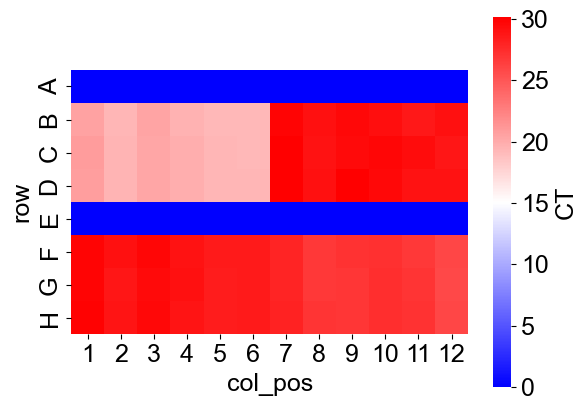

In [12]:
plot_heatmap(df, "CT")

In [13]:
### sample information

df = mergeDataFrames(df, cdnaT)

### sample name

df = pd.merge(df, sample, how="left", on="sample_id")
df["sample_name"] = df["sample_name"].fillna("noRT")
df.tail(12)

,Well Position,CT,plate,col_pos_x,primers,row,col_pos_y,sample_id,sample_name,rep,Experiment
84,H1,29.963804,plate1.xls,1,IL6,H,1,S1,Control 60' exp3,1.0,3.0
85,H2,28.830654,plate1.xls,2,IL6,H,2,S2,Control 60' exp3,2.0,3.0
86,H3,29.59663,plate1.xls,3,IL6,H,3,S3,Control 60' exp3,3.0,3.0
87,H4,28.933531,plate1.xls,4,IL6,H,4,S4,PEMF 60' exp3,1.0,3.0
88,H5,28.442444,plate1.xls,5,IL6,H,5,S5,PEMF 60' exp3,2.0,3.0
89,H6,28.570854,plate1.xls,6,IL6,H,6,S6,PEMF 60' exp3,3.0,3.0
90,H7,28.118238,plate1.xls,7,HSP70A,H,7,S1,Control 60' exp3,1.0,3.0
91,H8,26.947449,plate1.xls,8,HSP70A,H,8,S2,Control 60' exp3,2.0,3.0
92,H9,26.927002,plate1.xls,9,HSP70A,H,9,S3,Control 60' exp3,3.0,3.0
93,H10,27.404381,plate1.xls,10,HSP70A,H,10,S4,PEMF 60' exp3,1.0,3.0


# results 

## ct values

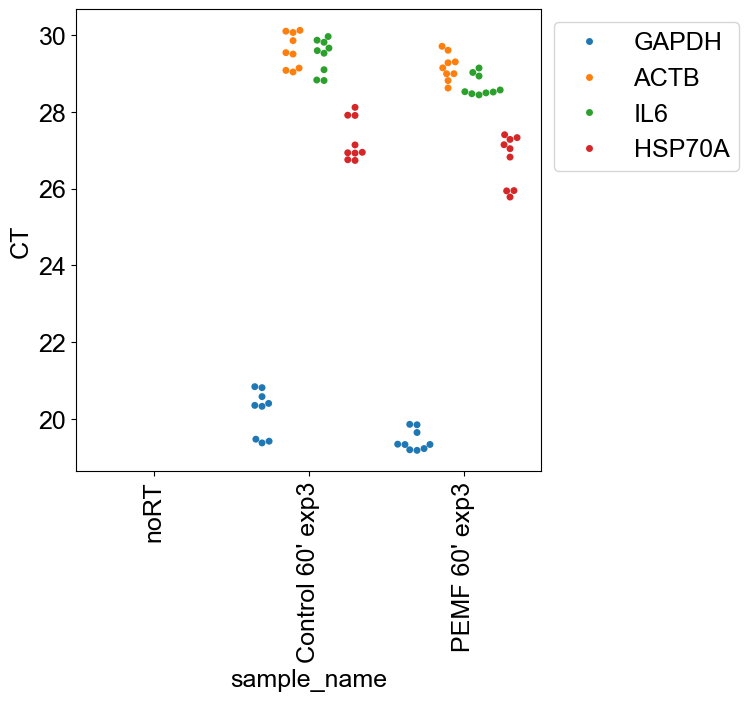

In [14]:
x="sample_name"
y="CT"
data=df#.loc[df["col_pos_x"].astype(int)!= 12]
hue="primers"
fig, ax=plt.subplots(figsize = (6,6))
sns.swarmplot(x=x, y=y, data=data, hue=hue, dodge=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(bbox_to_anchor=(1,1))

## ANOVA

### columns

In [15]:
test = df.loc[df["CT"].astype(str)!="None"].copy()

# change datatypes
test[["col_pos_x", "primers", "sample_id"]] = test[["col_pos_x", "primers", "sample_id"]].astype(str) 

test["CT"] = test["CT"].astype(float)
test = sm.add_constant(test)

mod = ols("CT ~ C(col_pos_x) + C(plate)" , data=test)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     CT   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     1.799
Date:                Tue, 16 Apr 2024   Prob (F-statistic):             0.0741
Time:                        14:53:53   Log-Likelihood:                -190.00
No. Observations:                  72   AIC:                             404.0
Df Residuals:                      60   BIC:                             431.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             25.3142      1

### primers and samples

In [16]:
test = df.loc[df["CT"].astype(str)!="None"].copy()

# change datatypes
test[["col_pos_x", "primers", "sample_id"]] = test[["col_pos_x", "primers", "sample_id"]].astype(str) 

test["CT"] = test["CT"].astype(float)
test = sm.add_constant(test)

mod = ols("CT ~ C(primers) + C(sample_name)" , data=test)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     CT   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1251.
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           3.85e-62
Time:                        14:54:00   Log-Likelihood:                -44.502
No. Observations:                  72   AIC:                             99.00
Df Residuals:                      67   BIC:                             110.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

## CT values

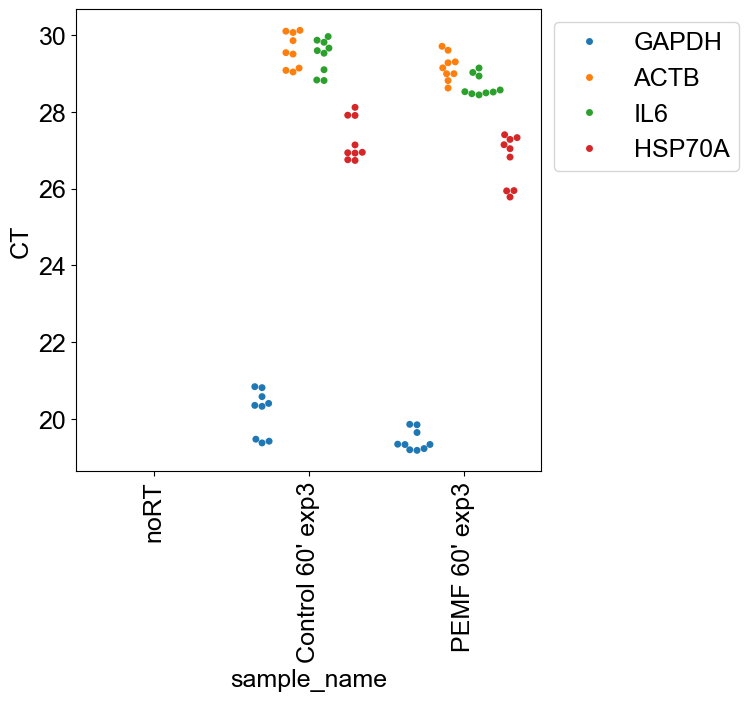

In [17]:
x="sample_name"
y="CT"
data=df#.loc[~df["col_pos_x"].isin([4, 12])]
hue="primers"

fig, ax=plt.subplots(figsize = (6,6))
sns.swarmplot(x=x, y=y, data=data, hue=hue, dodge=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(RE, f"{DATE}_CT_vals"), bbox_inches="tight")

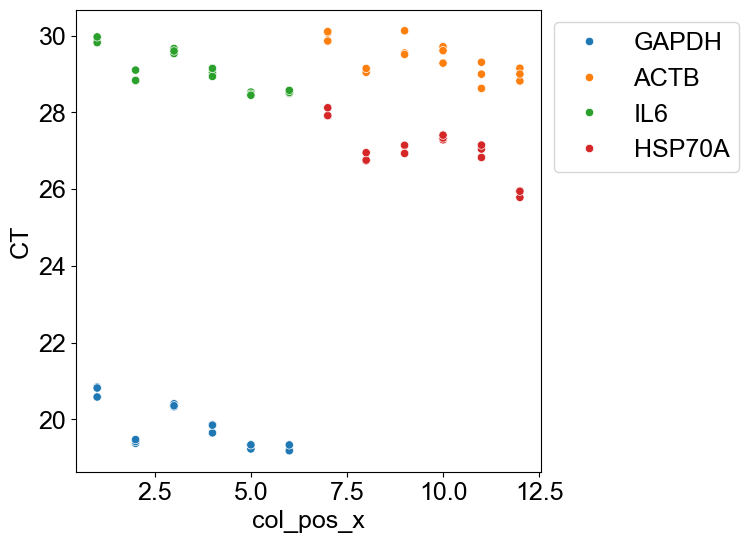

In [18]:
x="col_pos_x"
y="CT"
data=df
hue="primers"
fig, ax=plt.subplots(figsize = (6,6))
sns.scatterplot(x=x, y=y, data=data, hue=hue)
ax.legend(bbox_to_anchor=(1,1))

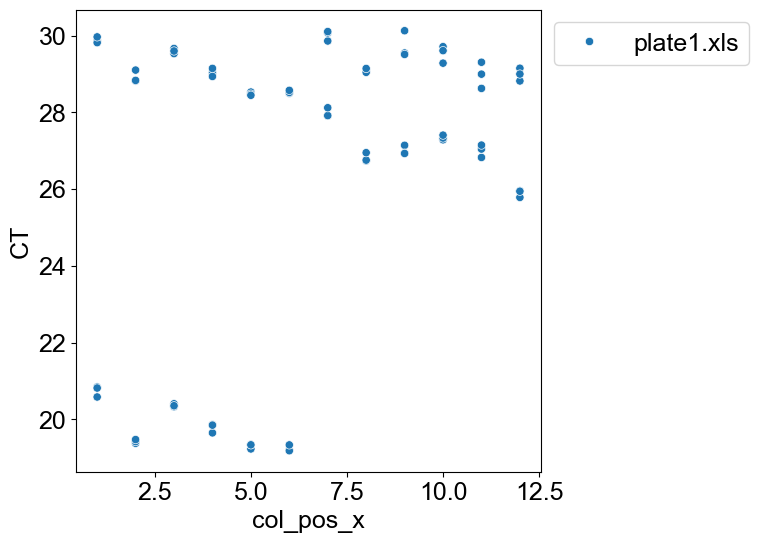

In [19]:
x="col_pos_x"
y="CT"
data=df
hue="plate"
fig, ax=plt.subplots(figsize = (6,6))
sns.scatterplot(x=x, y=y, data=data, hue=hue)
ax.legend(bbox_to_anchor=(1,1))

## compute ddCT with all datapoints

In [20]:
# columns for writing
write_cols = ['Well Position',
              'CT',
              'plate',
              'primers',
              'sample_name',
              'rep',
              'Experiment',
              'Control_mean',
              'dCT',
              'Control_dCT_mean',
              'ddCT',
              'fold_change', 
             "control_gene", 
             "date"]

results = {}

### actb

In [30]:
df

,Well Position,CT,plate,col_pos_x,row,col_pos_y,sample_id,sample_name,rep,Experiment,Control_mean,dCT,primers,Control_dCT_mean,ddCT,fold_change,control_gene


In [31]:
control_gene = "ACTB"
# mean ACTB CT per sample
mean_ctrl = df[df['primers'] == control_gene].groupby('sample_name')['CT'].mean().reset_index()

# rename columns
mean_ctrl.rename(columns={'CT': 'Control_mean'}, inplace=True)
mean_ctrl

,sample_name,Control_mean
0,Control 60' exp3,29.60742
1,PEMF 60' exp3,29.163599
2,noRT,NaN


In [32]:
# Merge mean ACTB values per sample
test = pd.merge(df, mean_ctrl, on='sample_name', how='left')

# dCT = obs CT - ACTB mean CT
test['dCT'] = test['CT'] - test['Control_mean']
test

,Well Position,CT,plate,col_pos_x,primers,row,col_pos_y,sample_id,sample_name,rep,Experiment,Control_mean,dCT
0,A1,None,plate1.xls,1,GAPDH,A,1,noRT,noRT,NaN,NaN,NaN,NaN
1,A2,None,plate1.xls,2,GAPDH,A,2,noRT,noRT,NaN,NaN,NaN,NaN
2,A3,None,plate1.xls,3,GAPDH,A,3,noRT,noRT,NaN,NaN,NaN,NaN
3,A4,NaN,plate1.xls,4,GAPDH,A,4,noRT,noRT,NaN,NaN,NaN,NaN
4,A5,NaN,plate1.xls,5,GAPDH,A,5,noRT,noRT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,H8,26.947449,plate1.xls,8,HSP70A,H,8,S2,Control 60' exp3,2.0,3.0,29.60742,-2.659971
92,H9,26.927002,plate1.xls,9,HSP70A,H,9,S3,Control 60' exp3,3.0,3.0,29.60742,-2.680418
93,H10,27.404381,plate1.xls,10,HSP70A,H,10,S4,PEMF 60' exp3,1.0,3.0,29.163599,-1.759219
94,H11,27.144958,plate1.xls,11,HSP70A,H,11,S5,PEMF 60' exp3,2.0,3.0,29.163599,-2.018641


In [45]:
control_gene = 'ACTB'

df_ = computeCT(df, control_gene)
df_["control_gene"]=control_gene
results[control_gene] = df_
df_.head()

,Well Position,CT,plate,col_pos_x,row,col_pos_y,sample_id,sample_name,rep,Experiment,Control_mean,dCT,primers,Control_dCT_mean,ddCT,fold_change,control_gene
0,B1,20.582415,plate1.xls,1,B,1,S1,Control 60' exp3,1.0,3.0,29.60742,-9.025005,GAPDH,-9.429901,0.404896,0.755291,ACTB
1,B2,19.375957,plate1.xls,2,B,2,S2,Control 60' exp3,2.0,3.0,29.60742,-10.231462,GAPDH,-9.429901,-0.801561,1.742986,ACTB
2,B3,20.405333,plate1.xls,3,B,3,S3,Control 60' exp3,3.0,3.0,29.60742,-9.202087,GAPDH,-9.429901,0.227814,0.853928,ACTB
3,B4,19.647526,plate1.xls,4,B,4,S4,PEMF 60' exp3,1.0,3.0,29.163599,-9.516074,GAPDH,-9.429901,-0.086173,1.06155,ACTB
4,B5,19.228903,plate1.xls,5,B,5,S5,PEMF 60' exp3,2.0,3.0,29.163599,-9.934697,GAPDH,-9.429901,-0.504795,1.418922,ACTB


PEMF 60' exp3 v. ctrl dCT IL6 0.06676394589658691
sample_name fold_change


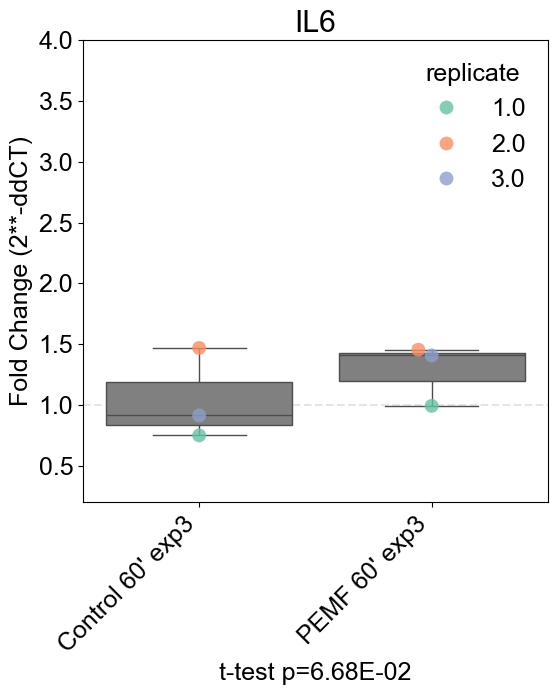

PEMF 60' exp3 v. ctrl dCT HSP70A 0.7951670846003799
sample_name fold_change


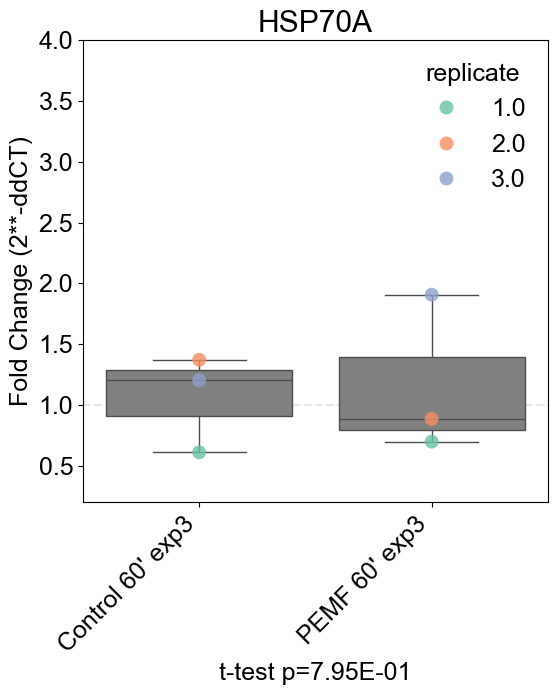

In [46]:
# Assuming 'df_' contains the 'fold_change' values, and you want to create a boxplot with points

# Set up the boxplot and swarmplot using Seaborn

for gene in GENE_LIST:
    plotDct(df_, gene, control_gene, COMPARISONS, DATE)

## GAPDH

PEMF 60' exp3 v. ctrl dCT IL6 0.7858048371151727
sample_name fold_change


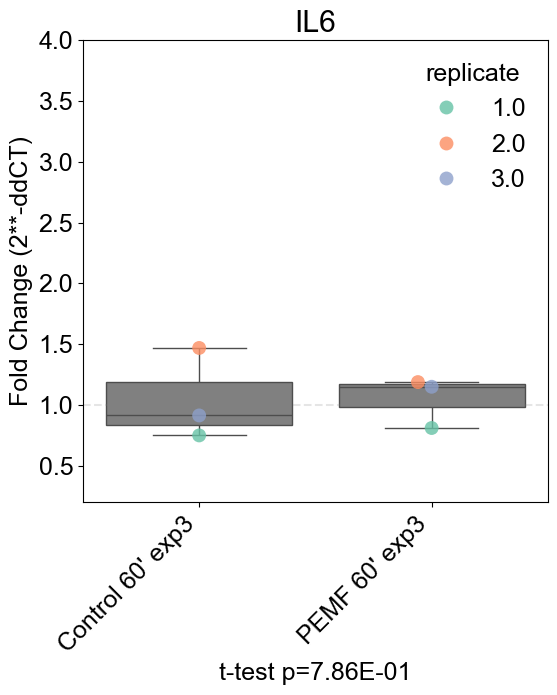

PEMF 60' exp3 v. ctrl dCT HSP70A 0.4646318607590504
sample_name fold_change


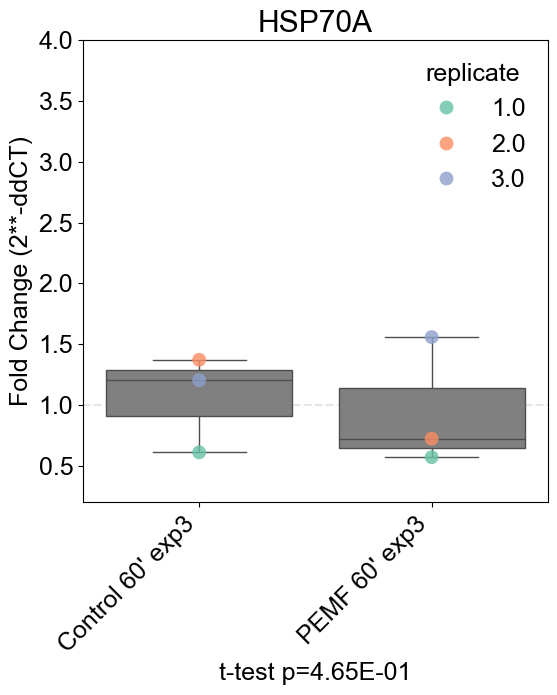

In [47]:
control_gene = 'GAPDH'
df_ = computeCT(df, control_gene)
df_["control_gene"]=control_gene
results[control_gene] = df_

for gene in GENE_LIST:
    plotDct(df_, gene, control_gene, COMPARISONS, DATE)

# write results 

In [48]:
re = pd.concat(results.values())
re["date"] = DATE
re[write_cols].to_csv(RE_DDCT, sep='\t', index=False)

In [49]:
RE_DDCT

'/wynton/home/ahituv/fongsl/EMF/results/20240411.ddCTs.HOb.tsv'

In [50]:
re

,Well Position,CT,plate,col_pos_x,row,col_pos_y,sample_id,sample_name,rep,Experiment,Control_mean,dCT,primers,Control_dCT_mean,ddCT,fold_change,control_gene,date
0,B1,20.582415,plate1.xls,1,B,1,S1,Control 60' exp3,1.0,3.0,29.60742,-9.025005,GAPDH,-9.429901,0.404896,0.755291,ACTB,20240411
1,B2,19.375957,plate1.xls,2,B,2,S2,Control 60' exp3,2.0,3.0,29.60742,-10.231462,GAPDH,-9.429901,-0.801561,1.742986,ACTB,20240411
2,B3,20.405333,plate1.xls,3,B,3,S3,Control 60' exp3,3.0,3.0,29.60742,-9.202087,GAPDH,-9.429901,0.227814,0.853928,ACTB,20240411
3,B4,19.647526,plate1.xls,4,B,4,S4,PEMF 60' exp3,1.0,3.0,29.163599,-9.516074,GAPDH,-9.429901,-0.086173,1.06155,ACTB,20240411
4,B5,19.228903,plate1.xls,5,B,5,S5,PEMF 60' exp3,2.0,3.0,29.163599,-9.934697,GAPDH,-9.429901,-0.504795,1.418922,ACTB,20240411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,H8,26.947449,plate1.xls,8,H,8,S2,Control 60' exp3,2.0,3.0,20.177519,6.76993,HSP70A,7.086804,-0.316874,1.245629,GAPDH,20240411
68,H9,26.927002,plate1.xls,9,H,9,S3,Control 60' exp3,3.0,3.0,20.177519,6.749483,HSP70A,7.086804,-0.337321,1.263408,GAPDH,20240411
69,H10,27.404381,plate1.xls,10,H,10,S4,PEMF 60' exp3,1.0,3.0,19.441968,7.962413,HSP70A,7.086804,0.875608,0.545024,GAPDH,20240411
70,H11,27.144958,plate1.xls,11,H,11,S5,PEMF 60' exp3,2.0,3.0,19.441968,7.70299,HSP70A,7.086804,0.616186,0.652393,GAPDH,20240411
